# Exploratory Data Analysis
## Introduction

This notebook is for exploring the data set after initial cleaning.

In [542]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Sometimes use display instead of print
from IPython.display import display

# queue data structure
from collections import deque

# debugging
from IPython.core.debugger import set_trace

%matplotlib inline

In [2]:
# Read the cleaned data
portfolio = pd.read_csv('./data/portfolio_clean.csv')
profile = pd.read_csv('./data/profile_clean.csv')
transcript = pd.read_csv('./data/transcript_clean.csv')

In [3]:
display(portfolio.head())
display(profile.head())
display(transcript.head())

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,7,10,10
1,2,1,1,1,1,bogo,5,10,10
2,3,1,1,1,0,informational,4,0,0
3,4,1,1,1,0,bogo,7,5,5
4,5,1,1,0,0,discount,10,20,5


,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


## Exploring the offer portfolio
Portfolio describes the offers shown to customers.

There are only 10 offers so we can look at them all. The difficulty is the amount a customer has to spend to get the reward amount. All the bogos ("buy one get one") have the same reward as their difficulty, whereas informational offers have no difficulty or reward.

In [4]:
portfolio.sort_values(['offer_type', 'duration'])

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
1,2,1,1,1,1,bogo,5,10,10
8,9,1,1,1,1,bogo,5,5,5
0,1,0,1,1,1,bogo,7,10,10
3,4,1,1,1,0,bogo,7,5,5
5,6,1,1,1,1,discount,7,7,3
9,10,1,1,1,0,discount,7,10,2
4,5,1,1,0,0,discount,10,20,5
6,7,1,1,1,1,discount,10,10,2
7,8,0,1,1,1,informational,3,0,0
2,3,1,1,1,0,informational,4,0,0


## Exploring the customer profiles


There are 17000 customers in the dataset. For most customers, (87%) we have gender, age, and income information as well. There are no customers where we partially have gender/age/information (i.e. all the NAs are in the same place).

In [5]:
profile.head()

,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


In [6]:
profile.shape

(17000, 5)

In [7]:
profile.gender.notnull().mean()

0.8720588235294118

In [8]:
# If all the NAs are in the same rows,
# exclusive OR will be 0.
# Only do 2/3 tests because of commutation.
print((profile.gender.isna() ^ profile.age.isna()).sum())
print((profile.gender.isna() ^ profile.income.isna()).sum())

0
0


<br/><br/>

Let's take a look at the distribution of the gender/age/income columns

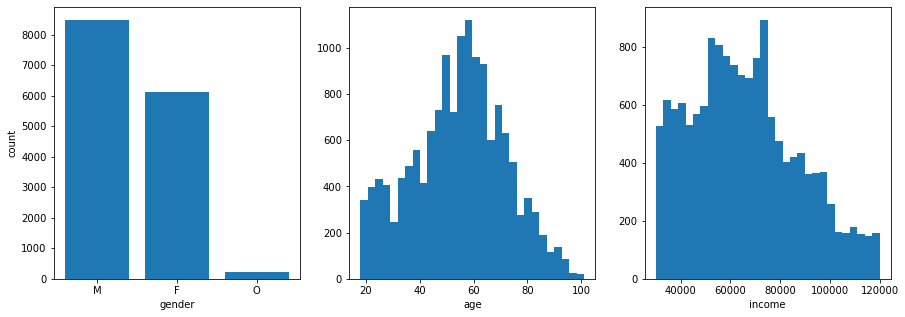

In [9]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15,5)
gender_plot = ax[0]
age_plot = ax[1]
income_plot = ax[2]

gender_plot.bar(profile.gender.value_counts().index, profile.gender.value_counts())
age_plot.hist(profile.age, 30)
income_plot.hist(profile.income, 30);

gender_plot.set_xlabel('gender')
gender_plot.set_ylabel('count')

age_plot.set_xlabel('age')
income_plot.set_xlabel('income');

<br/><br/>

The `became_member_on` column is currently not a datetime object, so let's change it.

In [10]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

In [11]:
# Summary of the column
profile.became_member_on.describe(datetime_is_numeric=True)

count                            17000
mean     2017-02-23 13:12:10.164706048
min                2013-07-29 00:00:00
25%                2016-05-26 00:00:00
50%                2017-08-02 00:00:00
75%                2017-12-30 00:00:00
max                2018-07-26 00:00:00
Name: became_member_on, dtype: object

<br><br>

There's are some chunks of when signs ups are.

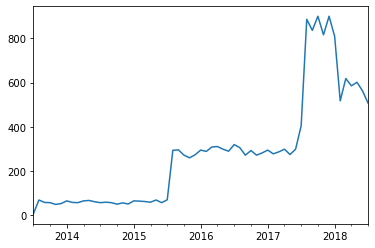

In [12]:
# User signups by month
profile.became_member_on.value_counts().resample("M").sum().plot();

## Exploring the transcript data

### Data overview

The `transcript` dataframe contains 306534 events over a period of one month (714 hours). During this time, a number of events can happen to customers (there are 17000 customers, which matches the number in the customer profiles). Customers may receive an offer ("offer_received"), view an offer ("offer_viewed"), complete an offer ("offer_completed"), and/or make a transaction ("transaction"). `amount` and `reward` are filled in for "offer_completed" events; `amount` is also filled in for "transaction" events.

In [13]:
print(f"Transcript shape is {transcript.shape}")
print(f"Start time is {transcript.time.min()}, end time is {transcript.time.max()} hours")
print(f"The number of unique customers in the transcript is {transcript.customer_id.nunique()}.")

Transcript shape is (306534, 6)
Start time is 0, end time is 714 hours
The number of unique customers in the transcript is 17000.


In [14]:
transcript.head(3)

,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0


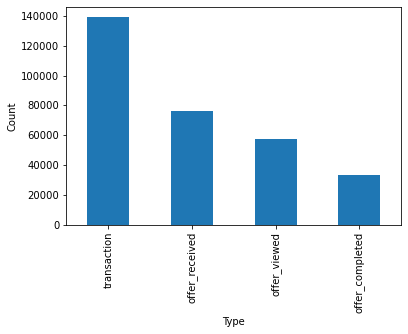

In [15]:
# Breakdown of event types.
ax = transcript.event.value_counts().plot(kind='bar')
ax.set_xlabel('Type')
ax.set_ylabel('Count');

<br/><br/>

### What is the distribution of transaction amounts?

The median transaction amount is 8.89 and the mean is 12.78. This distribution is right skewed: the 99th percentile is at 25.79, but 1% of transactions span all the way up to 1062.28. 

Although this dataset doesn't have the actual transaction items, I would speculate that the smaller distribution are mostly coffee orders, and the larger distribution is coffee + food .
What is the smallest ting?

In [16]:
transactions = transcript[transcript.event == 'transaction']

In [17]:
transactions.head(3)

,customer_id,time,event,amount,reward,offer_id
12654,42,0,transaction,0.83,NaN,NaN
12657,56,0,transaction,34.56,NaN,NaN
12659,64,0,transaction,13.23,NaN,NaN


In [18]:
transactions.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [19]:
print(f"Quantiles: 90%, {round(transactions.amount.quantile(q=0.90), 2)}.\n"
      f"           95%, {round(transactions.amount.quantile(q=0.95), 2)}.\n"
      f"           99%, {round(transactions.amount.quantile(q=0.99), 2)}.")

Quantiles: 90%, 25.49.
           95%, 29.91.
           99%, 40.02.


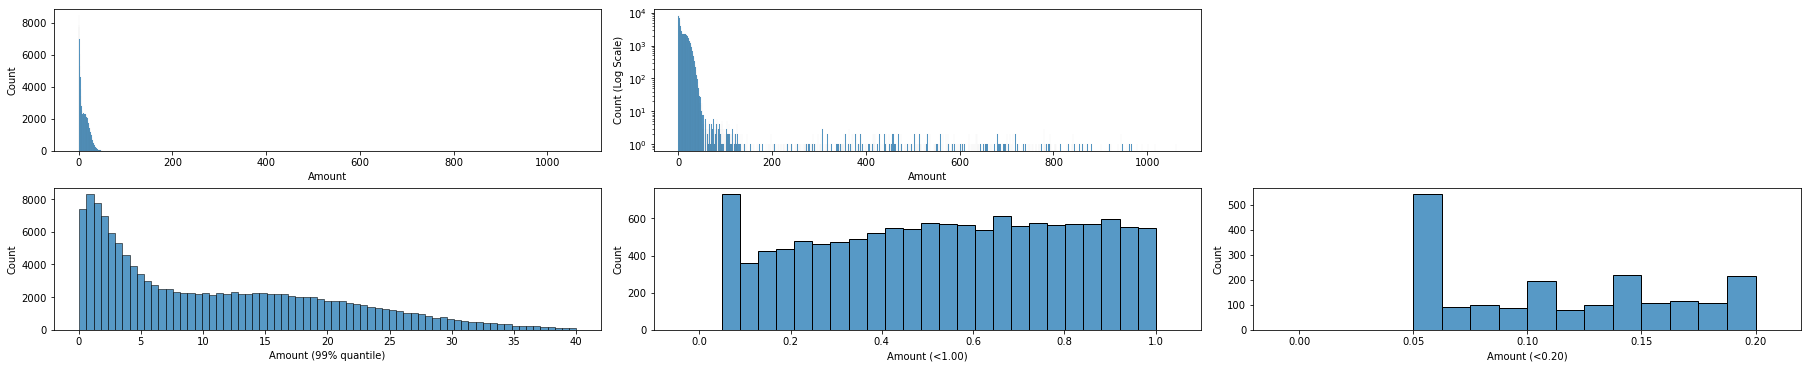

In [20]:
# Transaction amounts
fig, ax = plt.subplots(2, 3, figsize=(25,5), constrained_layout=True)
sns.histplot(data=transactions, x='amount', ax=ax[0,0])
sns.histplot(data=transactions, x='amount', ax=ax[0,1])
sns.histplot(data=transactions[transactions.amount <= 40.02], x='amount', ax=ax[1,0])
sns.histplot(data=transactions[transactions.amount <= 1.00], x='amount', ax=ax[1,1])
sns.histplot(data=transactions[transactions.amount <= 0.2], x='amount', ax=ax[1,2])
ax[0,0].set_xlabel('Amount')
ax[0,1].set_yscale('log')
ax[0,1].set_ylabel('Count (Log Scale)')
ax[0,1].set_xlabel('Amount')
ax[0,2].axis('off')
ax[1,0].set_xlim(0-2,40.02+2)
ax[1,0].set_xlabel('Amount (99% quantile)')
ax[1,1].set_xlim(0-0.1, 1+0.1)
ax[1,1].set_xlabel('Amount (<1.00)')
ax[1,2].set_xlim(0-0.02, 0.2+0.02)
ax[1,2].set_xlabel('Amount (<0.20)');

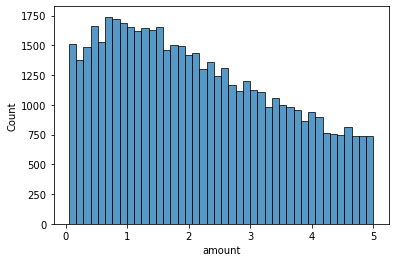

In [21]:
# A look at 0 to 5 dollars
ax = sns.histplot(data=transactions[transactions.amount <= 5], x='amount')

In [22]:
print(f"Number of transactions at 0.05: {(transactions.amount == 0.05).sum()}")

Number of transactions at 0.05: 431


### What is the distribution of transactions per person.
There's several questions we can ask here.
    - What is the spend per person in this time period in terms of
        - The distribution of totals.
        - 

count    16578.000000
mean       107.096874
std        126.393939
min          0.050000
25%         23.682500
50%         72.410000
75%        150.937500
max       1608.690000
Name: amount, dtype: float64

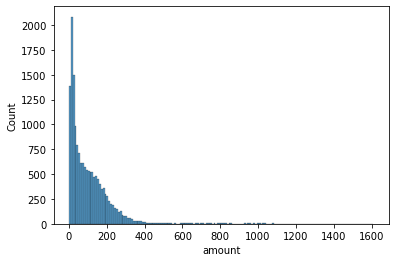

In [23]:
# Distribution of total spend per person.
tpc = transactions.groupby('customer_id')['amount'] # Transactions Per Customer
display(tpc.sum().describe())
sns.histplot(data=tpc.sum());

count    16578.000000
mean         8.381771
std          5.009822
min          1.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: amount, dtype: float64

<AxesSubplot:xlabel='amount', ylabel='Count'>

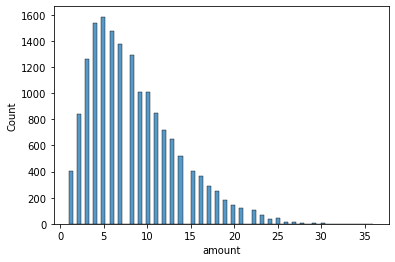

In [24]:
# Distribution of number of transactions per person.
display(tpc.count().describe())
sns.histplot(data=tpc.count())

In [25]:
# Sanity check that the customer ordering for the count and the sum are the same.
(tpc.count().index == tpc.sum().index).all()

True

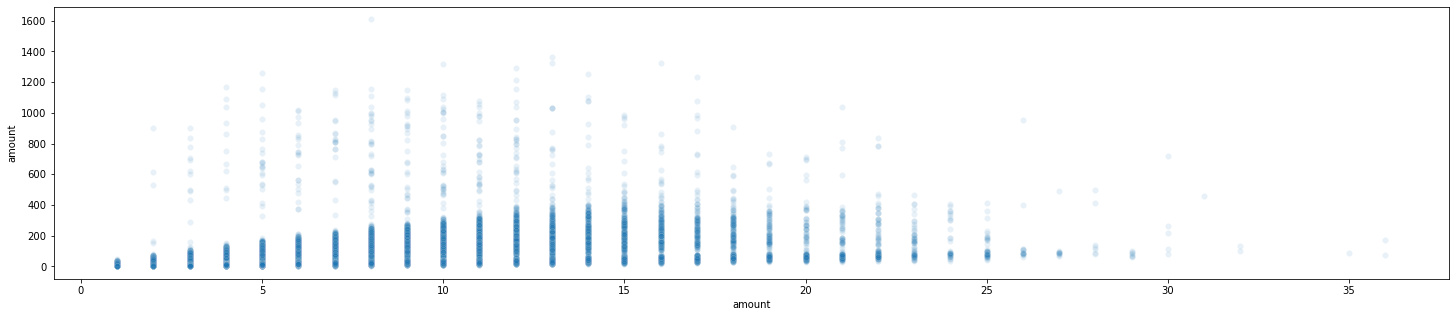

In [26]:
fig, ax = plt.subplots(figsize=(25,5))
sns.scatterplot(x=tpc.count(), y=tpc.sum(), alpha=0.1, ax=ax);

### What is the relationship between transactions and customer variables?

Let's take a look at the sum of transactions vs a customers age, income, and gender. 

Note: The O (other) gender is much smaller than M and F in number.

In [150]:
# tpc: transactions per customer
tpc_cust_vars = tpc.sum().to_frame().merge(profile, left_index=True, right_on='customer_id', how='left')
tpc_cust_vars.head(2)

,amount,customer_id,gender,age,income,became_member_on
0,20.40,1,NaN,NaN,NaN,2017-02-12
1,77.01,2,F,55.0,112000.0,2017-07-15


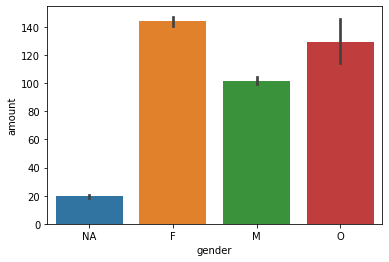

In [155]:
sns.barplot(data=tpc_cust_vars.fillna({'gender':'NA'}), x='gender', y='amount');

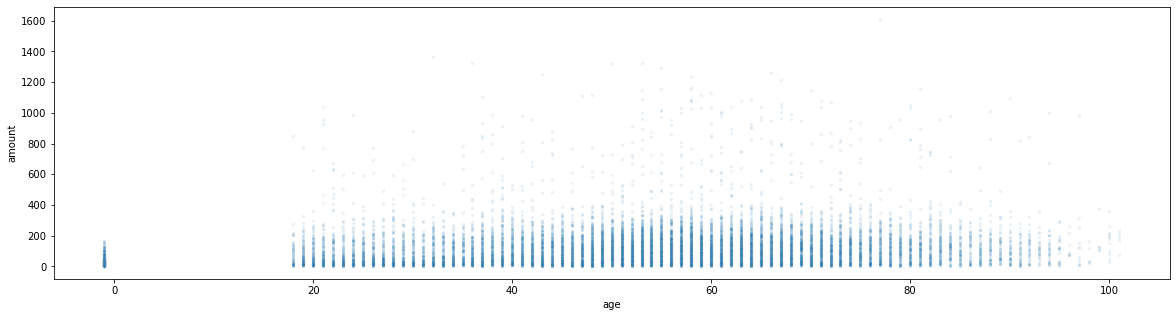

In [163]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.scatterplot(ax=ax, data=tpc_cust_vars.fillna({'age':-1}), x='age', y='amount', s=10, alpha=0.1);

<br><br>

Income vs. amount spent, seems like there are two distributions. Both of these distributions look like they have a positive trend.

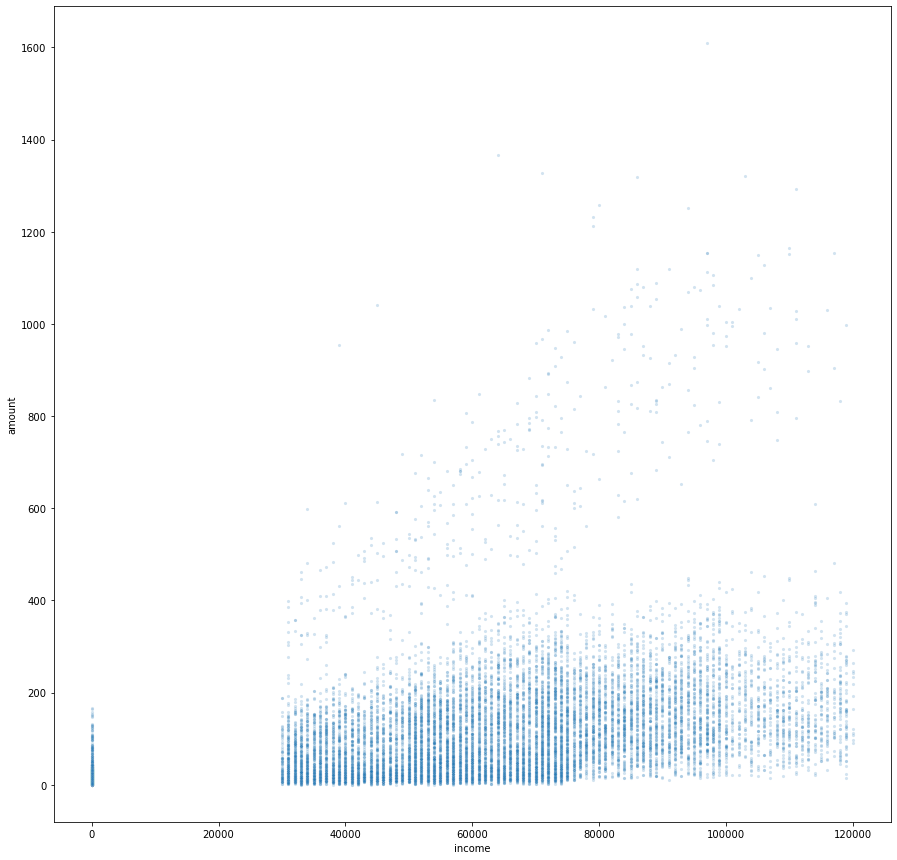

In [166]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(ax=ax, data=tpc_cust_vars.fillna({'income': -1}), x='income', y='amount', s=10, alpha=0.2);

<br><br>

Again, you can see some of the chunking of the user sign up dates.

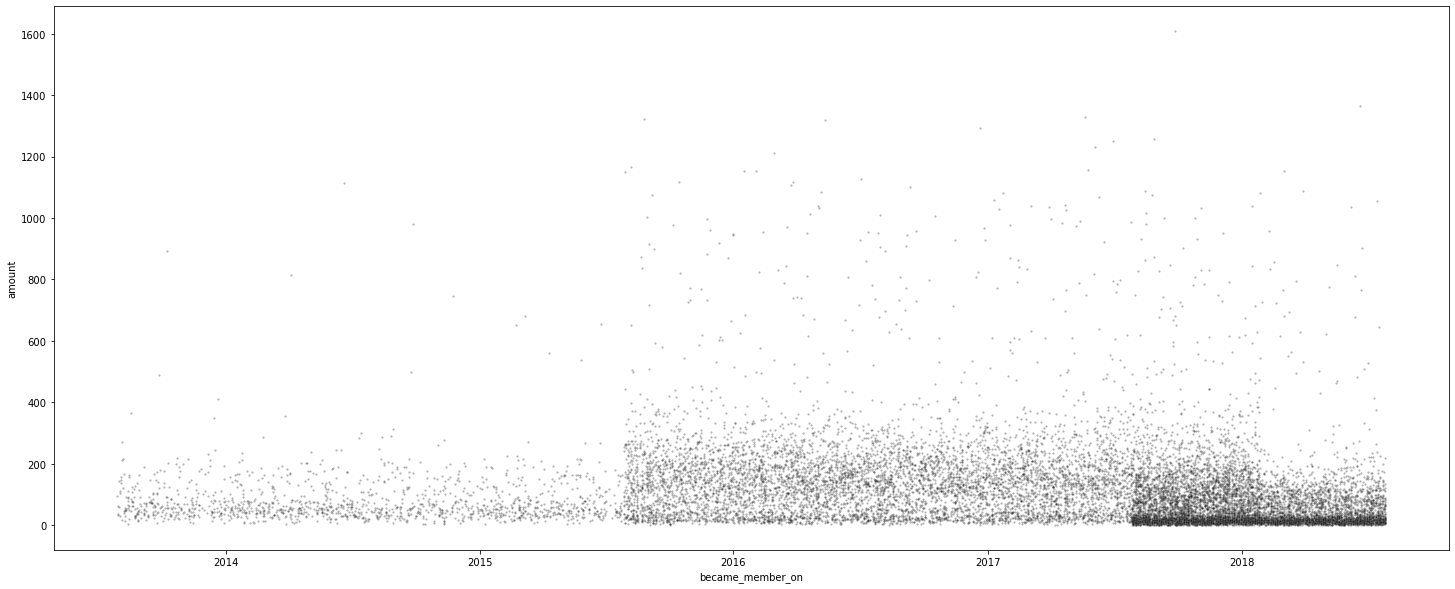

In [174]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(ax=ax, data=tpc_cust_vars, x='became_member_on', y='amount', s=5, alpha=0.3, c=['black']);

In [145]:
profile.head()

,customer_id,gender,age,income,became_member_on
0,1,NaN,NaN,NaN,2017-02-12
1,2,F,55.0,112000.0,2017-07-15
2,3,NaN,NaN,NaN,2018-07-12
3,4,F,75.0,100000.0,2017-05-09
4,5,NaN,NaN,NaN,2017-08-04


### When are which offers given?

All ten offers are given at all six time points.

In [107]:
received_events = transcript[transcript.event == 'offer_received']
offer_times = received_events.groupby('offer_id')['time'].unique()
offer_times = pd.DataFrame(offer_times.values.tolist(), index=offer_times.index)
offer_times = offer_times.merge(portfolio[['offer_id', 'offer_type']], left_index=True, right_on='offer_id')
display(offer_times)

,0,1,2,3,4,5,offer_id,offer_type
0,0,168,336,408,504,576,1,bogo
1,0,168,336,408,504,576,2,bogo
2,0,168,336,408,504,576,3,informational
3,0,168,336,408,504,576,4,bogo
4,0,168,336,408,504,576,5,discount
5,0,168,336,408,504,576,6,discount
6,0,168,336,408,504,576,7,discount
7,0,168,336,408,504,576,8,informational
8,0,168,336,408,504,576,9,bogo
9,0,168,336,408,504,576,10,discount


### How many customers are given each offer at each time point?

No customers getting more than one offer at a certain time point:

In [223]:
# Are there any customers with more than one more at the same time point?
# Max will be > 1 if there is more than one offer at one time point
# (shouldn't have to be unique offers to be > 1).
# Max is 1, so only 1 offer is given at each time point.
received_events.groupby(['customer_id', 'time']).count()['event'].max()

1

Given that no customers have multiple offers at one time point, the number of customers not getting an offer at any time point is simply the total number of customers minus the number of customers with offers.

The table below shows this.

In [143]:
offer_counts = received_events.groupby(['offer_id', 'time'])[['customer_id']].count()
offer_counts = offer_counts.unstack()['customer_id']
offer_counts.loc['no_offer', :] = transcript.customer_id.nunique() - offer_counts.sum()
offer_counts = offer_counts.astype('int')
display(offer_counts)

time,0,168,336,408,504,576
offer_id,,,,,,
1.0,1292,1319,1245,1278,1248,1276
2.0,1218,1240,1280,1308,1310,1237
3.0,1273,1266,1279,1275,1229,1295
4.0,1245,1296,1275,1274,1261,1326
5.0,1297,1245,1322,1269,1258,1277
6.0,1221,1250,1301,1274,1286,1314
7.0,1318,1250,1243,1222,1283,1281
8.0,1266,1270,1256,1293,1238,1295
9.0,1263,1263,1247,1250,1305,1243


### Are customers given unique offers each time?

Customers may get the same offer more than once. Here is an example customer where offer 7 was offered to them twice.

In [212]:
# Example customer with repeated offer 7
received_events[received_events.customer_id == 1]

,customer_id,time,event,amount,reward,offer_id
53174,1,168,offer_received,NaN,NaN,10.0
110828,1,336,offer_received,NaN,NaN,5.0
150596,1,408,offer_received,NaN,NaN,7.0
201570,1,504,offer_received,NaN,NaN,6.0
245122,1,576,offer_received,NaN,NaN,7.0


<br><br>
This is a count of the number of unique and the total number of offers each customer receives.

,Number of Offers,Type,Count
0,1,unique_offers,172
1,2,unique_offers,1599
2,3,unique_offers,5038
3,4,unique_offers,6563
4,5,unique_offers,3180
5,6,unique_offers,442
6,1,total_offers,73
7,2,total_offers,610
8,3,total_offers,2325
9,4,total_offers,4988


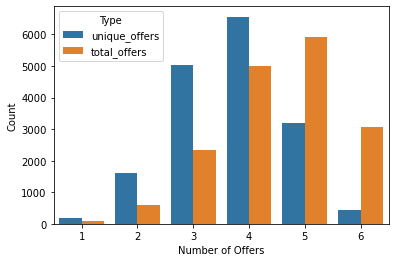

In [205]:
# Number of unique offers per customer in the transcript
unique_offers_per_cust_s = received_events.groupby(['customer_id'])['offer_id'].nunique().value_counts().sort_index()
# Total number of offers per customer
offers_per_cust_s = received_events.groupby(['customer_id'])['offer_id'].count().value_counts().sort_index()
# Disposable dataframe combining the two series above, with some housekeeping on col/index names
_frame = pd.concat([unique_offers_per_cust_s, offers_per_cust_s], axis=1)\
                  .set_axis(['unique_offers', 'total_offers'], axis=1)\
                  .reset_index()\
                  .melt(id_vars='index')
_frame = _frame.rename(columns={'value': 'Count', 'variable':'Type', 'index':'Number of Offers'})
sns.barplot(data=_frame, x='Number of Offers', y='Count', hue='Type')
display(_frame)

<br><br><br>
### Are offers being given randomly?

Here, I plot the customer ids on the x axis, and time on the y axis (for the time point that offers are offered). The distribution seems random across customer ids.

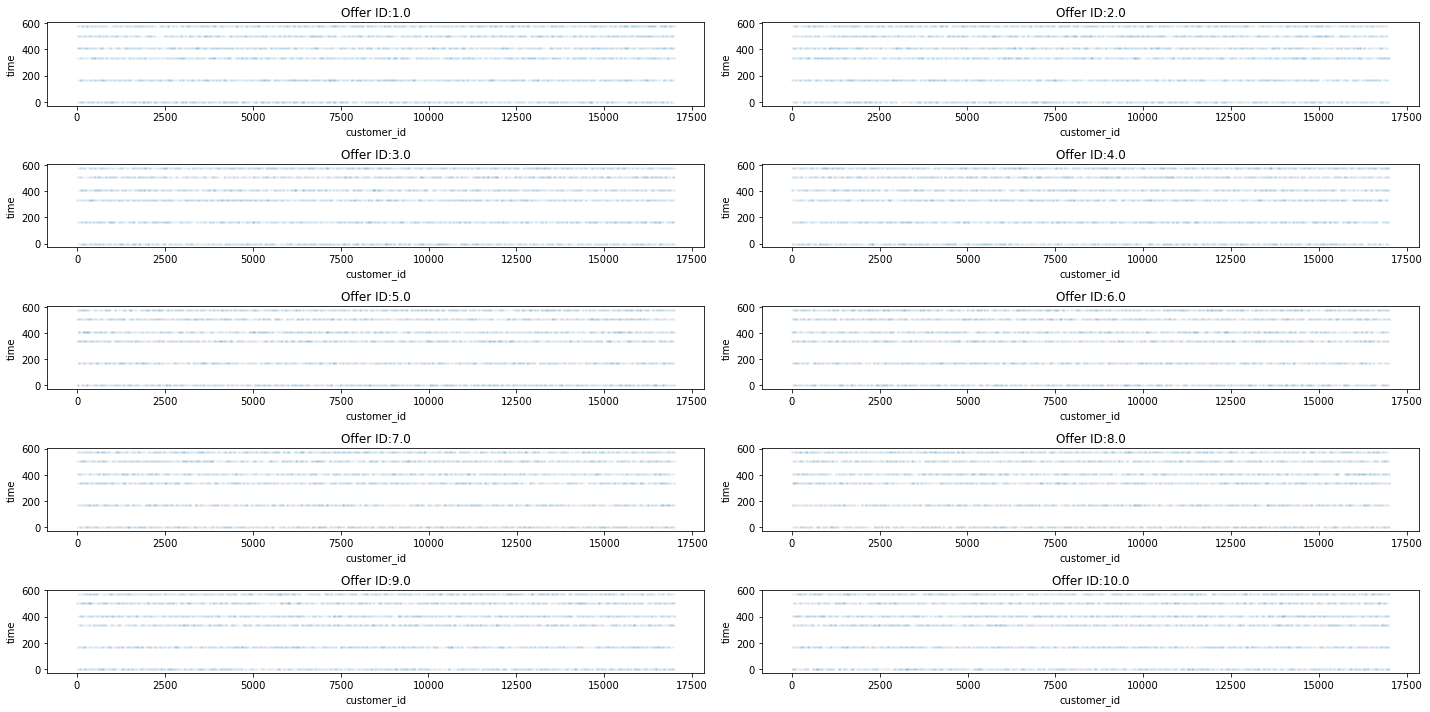

In [260]:
fig, ax = plt.subplots(5, 2, figsize=(20,10))
ax = ax.flatten()
for i, group in enumerate(received_events.groupby(['offer_id'])):
    sns.scatterplot(ax=ax[i], data=group[1], x='customer_id', y='time', alpha=0.05, s=5)
    ax[i].title.set_text(f"Offer ID:{group[0]}")

plt.tight_layout()

<br><br><br>

### When an offer is given, when is it viewed?

offer was given to a customer. Look for when that customer viewed. What's that time.
Offer was given to a whole bunch of customers.
For each offer at each timepoint. You ahve a list of customers. 
    did those customers view it. In the time between each set of time points.
    Did they view it after that?

In [266]:
# The timepoints when offers were made, plus the max time of the experiment
timepoints = np.append(received_events.time.unique(), transcript.time.max())
display(timepoints)

array([  0, 168, 336, 408, 504, 576, 714])

In [273]:
test1 = received_events.groupby(['offer_id','time'])
test1a = test1.get_group((1,0))

In [274]:
test1a

,customer_id,time,event,amount,reward,offer_id
12,22,0,offer_received,NaN,NaN,1.0
19,33,0,offer_received,NaN,NaN,1.0
27,42,0,offer_received,NaN,NaN,1.0
35,300,0,offer_received,NaN,NaN,1.0
39,59,0,offer_received,NaN,NaN,1.0
...,...,...,...,...,...,...
12544,5247,0,offer_received,NaN,NaN,1.0
12565,16896,0,offer_received,NaN,NaN,1.0
12566,16897,0,offer_received,NaN,NaN,1.0
12587,16925,0,offer_received,NaN,NaN,1.0


In [289]:
test1b = transcript[(transcript.event == 'offer_viewed') & (transcript.customer_id.isin(test1a.customer_id)) & (transcript.time >= 0) & (transcript.time <168)]
test1b.insert(0, "count", range(1, 1 + len(test1b)))

In [290]:
test1b

,count,customer_id,time,event,amount,reward,offer_id
12653,1,42,0,offer_viewed,NaN,NaN,1.0
12665,2,108,0,offer_viewed,NaN,NaN,1.0
12669,3,134,0,offer_viewed,NaN,NaN,1.0
12674,4,161,0,offer_viewed,NaN,NaN,1.0
12680,5,176,0,offer_viewed,NaN,NaN,1.0
...,...,...,...,...,...,...,...
51223,1177,14581,150,offer_viewed,NaN,NaN,1.0
51566,1178,4083,156,offer_viewed,NaN,NaN,1.0
52624,1179,6650,162,offer_viewed,NaN,NaN,1.0
53007,1180,14027,162,offer_viewed,NaN,NaN,1.0


In [316]:
test1c = transcript[(transcript.event == 'offer_completed') & (transcript.customer_id.isin(test1a.customer_id)) & (transcript.time >= 0) & (transcript.time <168)]
test1c.insert(0, "count", range(1, 1 + len(test1c)))

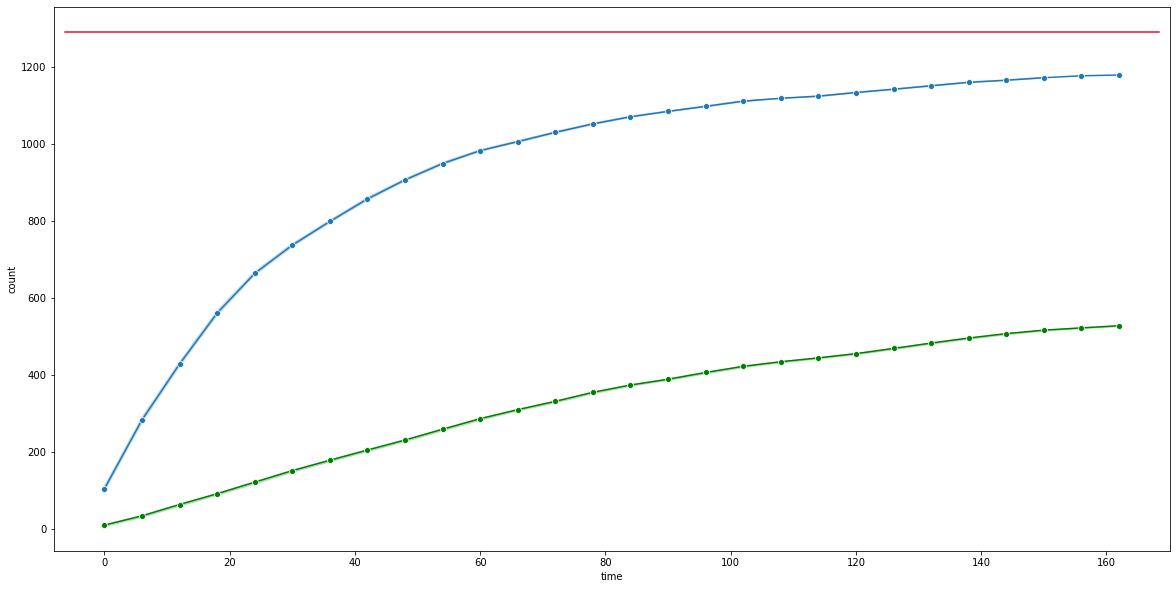

In [317]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(ax=ax, data=test1b, x='time', y='count', marker='o');
sns.lineplot(ax=ax, data=test1c, x='time', y='count', marker='o', color='green')
ax.axhline(len(test1a), xmin=0.01, xmax=0.99, color='crimson');

In [ ]:
def plot_offer_subplot(group, ax):
    """
    
    """
    

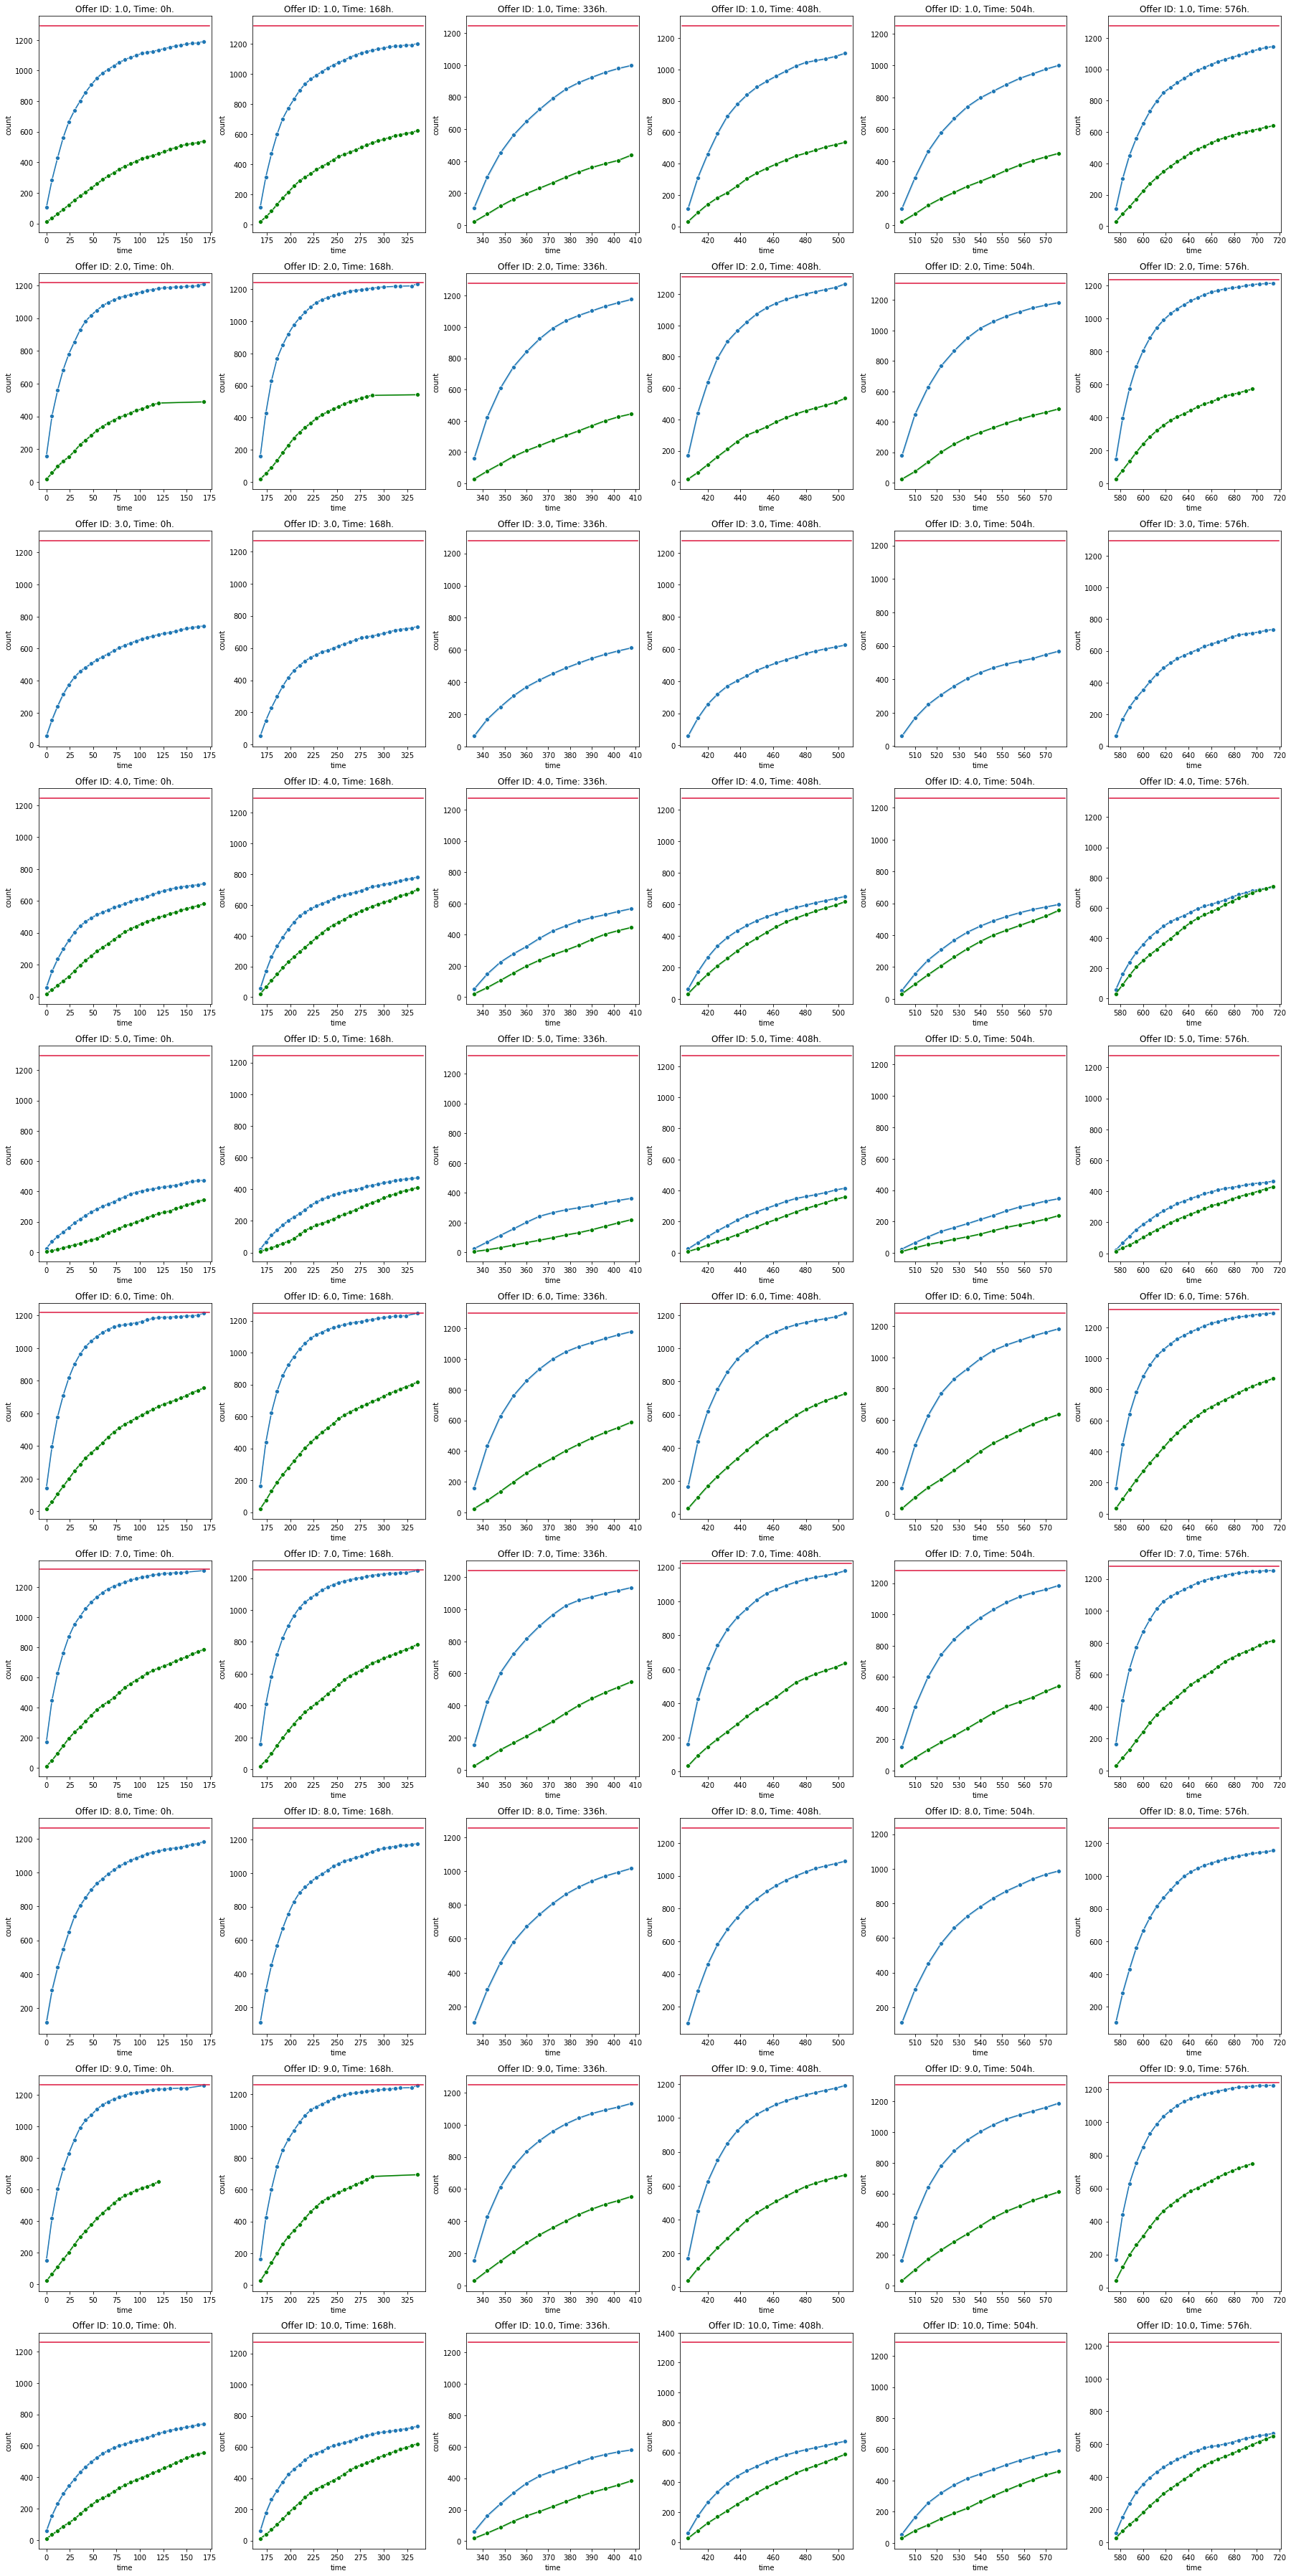

In [371]:
offer_groups = received_events.groupby(['offer_id', 'time'])

offer_keys = list(offer_groups.groups.keys())
_df = pd.DataFrame(offer_keys) # temp df
offer_ids = _df[0].unique() # offer ids
# timepoints of the offers, 
# but add the transcript terminal timepoint for for loop convenience
timepoints = np.append(_df[1].unique(), transcript.time.max()) 

# TODO dimension are some W x H
# 6 offer time points, 10 offers
fig, axes = plt.subplots(len(offer_ids), len(timepoints[:-1]), figsize=(25, 50))

# Double for loop is better for offer ids and timeponts
for i, o_id in enumerate(offer_ids):
    # Offer timepoints only, exclude the max time
    for j, tp in enumerate(timepoints[0:-1]):
        # customers of the current group to plot
        curr_customers = offer_groups.get_group((o_id, tp))['customer_id']
        # events from the transcript relevant to the current group to plot
        curr_events = transcript[(transcript['offer_id'] == o_id) & # current offer id
                                 (transcript['customer_id'].isin(curr_customers)) & # current customers
                                 (transcript['time'] >= tp) & # starting at current timepoint
                                 (transcript['time'] <= timepoints[j+1]) # ending before the next offer time, or the end
                                ]
        
        # Dataframes of when current customers view/complete the current offer
        # TODO this doesn't distinguish offers that were viewed not in the current offer period.
        view_events = curr_events[curr_events['event'] == 'offer_viewed']
        complete_events = curr_events[curr_events['event'] == 'offer_completed']
        
        # Add a count columns for plotting accumulation
        view_events.insert(0, "count", range(1, 1 + len(view_events)))
        complete_events.insert(0, "count", range(1, 1 + len(complete_events)))

        # Plot each group, offers in the row, timepoints in the columns
        ax = axes[i,j]
        sns.lineplot(ax=ax, data=view_events, x='time', y='count', marker='o')
        sns.lineplot(ax=ax, data=complete_events, x='time', y='count', marker='o', color='green')
        ax.axhline(len(curr_customers), xmin=0.01, xmax=0.99, color='crimson');
        ax.set_title(f"Offer ID: {o_id}, Time: {int(tp)}h.")

plt.tight_layout()

In [372]:
portfolio

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,7,10,10
1,2,1,1,1,1,bogo,5,10,10
2,3,1,1,1,0,informational,4,0,0
3,4,1,1,1,0,bogo,7,5,5
4,5,1,1,0,0,discount,10,20,5
5,6,1,1,1,1,discount,7,7,3
6,7,1,1,1,1,discount,10,10,2
7,8,0,1,1,1,informational,3,0,0
8,9,1,1,1,1,bogo,5,5,5
9,10,1,1,1,0,discount,7,10,2


In [27]:
# For each offer, for each time, when are viewing events.
# Can use a cumulative plot.

In [28]:
# Test plot with just one offer, at one time.

# so we need offer == 1.0
# time == 0
# a df .... ..... offer received, selector
# customers will view offers for indeterminate time.

# second filter
# offer viewed # 

# Is there anyone that received an offer but completed after the next batch of offers is sent.

What does DURATION really mean?



In [373]:
# Duration of offers in hours
# TODO this should be in data cleaning.
portfolio['duration'] = portfolio['duration'] * 24

In [374]:
portfolio

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5
5,6,1,1,1,1,discount,168,7,3
6,7,1,1,1,1,discount,240,10,2
7,8,0,1,1,1,informational,72,0,0
8,9,1,1,1,1,bogo,120,5,5
9,10,1,1,1,0,discount,168,10,2


In [377]:
# Is the duration from when the offer is viewed to when it's completed?

# Let's get for each view event, the offer, how much longer after they view it is completed.
offer_groups.get_group((1,0)).customer_id
# 

(1292,)

In [415]:
test = transcript[(transcript.offer_id == 1) & ((transcript.event == 'offer_viewed') | (transcript.event == 'offer_completed'))].sort_values(['customer_id', 'offer_id']).groupby(['customer_id'])
display(test.get_group(4))

# should group by this.

,customer_id,time,event,amount,reward,offer_id
163375,4,408,offer_viewed,NaN,NaN,1.0
218394,4,510,offer_completed,NaN,10.0,1.0


In [420]:
2343 not in test.get_group(4)

True

In [ ]:
# apply a function here to the group by object
# I've grouoped by customer id.
# for each customer
# do I need to group by offer id?

# what i'm really asking is , if the n of offer_received > offer_viewed > offer_completed


In [424]:
def test_helper(x):
    counts = x.value_counts()
    for idx in ['offer_received', 'offer_viewed', 'offer_completed']:
        if idx not in counts.index:
            counts[idx] = 0
    #return counts['offer_received'] > counts['offer_viewed'] > counts['offer_completed']
    return pd.Series([counts['offer_received'] < counts['offer_viewed'], counts['offer_viewed'] < counts['offer_completed'], counts['offer_received'] < counts['offer_completed']])

result = transcript.groupby(['customer_id', 'offer_id'])['event'].apply(test_helper)

In [426]:
result.head()

customer_id  offer_id   
1            5.0       0    False
                       1    False
                       2    False
             6.0       0    False
                       1    False
Name: event, dtype: bool

In [430]:
# There are a bunch of offers completed without offered viewed.
print(result[result.index.get_level_values(2) == 0].sum())
print(result[result.index.get_level_values(2) == 1].sum())
print(result[result.index.get_level_values(2) == 2].sum())

0
5276
0


In [ ]:
# Now... need to get the value of it..
# We know always starts with received.

In [401]:
transcript.groupby(['customer_id', 'offer_id']).get_group((4,1))['event'].value_counts()

offer_received     1
offer_completed    1
offer_viewed       1
Name: event, dtype: int64

In [404]:
transcript.groupby(['customer_id', 'offer_id'])['event'].value_counts()

customer_id  offer_id  event          
1            5.0       offer_received     1
                       offer_viewed       1
             6.0       offer_completed    1
                       offer_received     1
                       offer_viewed       1
                                         ..
17000        6.0       offer_received     1
                       offer_viewed       1
             9.0       offer_completed    1
                       offer_received     1
                       offer_viewed       1
Name: event, Length: 141419, dtype: int64

In [434]:
transcript.groupby(['customer_id', 'offer_id'])[['time','event']].get_group((4,1))

,time,event
150598,408,offer_received
163375,408,offer_viewed
218394,510,offer_completed


In [439]:
# All offer chains start with event received.
transcript.groupby(['customer_id', 'offer_id'])[['time','event']].apply(lambda x: x.iloc[0]['event'] != 'offer_received').sum()

0

In [472]:
transcript[transcript.customer_id == 4]

,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
15561,4,6,offer_viewed,NaN,NaN,4.0
47582,4,132,transaction,19.89,NaN,NaN
47583,4,132,offer_completed,NaN,5.0,4.0
49502,4,144,transaction,17.78,NaN,NaN
53176,4,168,offer_received,NaN,NaN,8.0
85291,4,216,offer_viewed,NaN,NaN,8.0
87134,4,222,transaction,19.67,NaN,NaN
92104,4,240,transaction,29.72,NaN,NaN
141566,4,378,transaction,23.93,NaN,NaN


In [639]:
test = transcript.groupby(['customer_id', 'offer_id']).apply(lambda df: df.assign(time_diff=df.time.diff()))

In [642]:
test.shape

(167581, 7)

In [641]:
test.head(20)

customer_id  time            event  amount  \
customer_id offer_id                                                      
1           5.0      110828            1   336   offer_received     NaN   
                     130147            1   348     offer_viewed     NaN   
            6.0      201570            1   504   offer_received     NaN   
                     214274            1   504     offer_viewed     NaN   
                     237366            1   552  offer_completed     NaN   
            7.0      150596            1   408   offer_received     NaN   
                     163374            1   408     offer_viewed     NaN   
                     237365            1   552  offer_completed     NaN   
                     245122            1   576   offer_received     NaN   
                     262137            1   582     offer_viewed     NaN   
            10.0     53174             1   168   offer_received     NaN   
                     85290             1   216     offer_viewed     NaN   
2           3.0      201571            2   504   offer_received     NaN   
            4.0      150597            2   408   offer_received     NaN   
                     227843            2   528  offer_completed     NaN   
3           4.0      53175             3   168   offer_received     NaN   
                     65843             3   168     offer_viewed     NaN   
            8.0      245123            3   576   offer_received     NaN   
                     294714            3   666     offer_viewed     NaN   
4           1.0      150598            4   408   offer_received     NaN   

                             reward  offer_id  time_diff  
customer_id offer_id                                      
1           5.0      110828     NaN       5.0        NaN  
                     130147     NaN       5.0       12.0  
            6.0      201570     NaN       6.0        NaN  
                     214274     NaN       6.0        0.0  
                     237366     3.0       6.0       48.0  
            7.0      150596     NaN       7.0        NaN  
                     163374     NaN       7.0        0.0  
                     237365     2.0       7.0      144.0  
                     245122     NaN       7.0       24.0  
                     262137     NaN       7.0        6.0  
            10.0     53174      NaN      10.0        NaN  
                     85290      NaN      10.0       48.0  
2           3.0      201571     NaN       3.0        NaN  
            4.0      150597     NaN       4.0        NaN  
                     227843     5.0       4.0      120.0  
3           4.0      53175      NaN       4.0        NaN  
                     65843      NaN       4.0        0.0  
            8.0      245123     NaN       8.0        NaN  
                     294714     NaN       8.0       90.0  
4           1.0      150598     NaN       1.0        NaN

In [660]:

# previous row's offer and event type

# combination
# event is completed
# previous event is the same offer, and also completed
# grab all those current lines

test2 = test[test.customer_id.isin(
                                    test[
                                     (test.event == 'offer_completed') &
                                     (test.event.shift() == 'offer_completed') &
                                     (test.offer_id == test.offer_id.shift())
                                    ].customer_id
                                   )]


In [662]:
test2.shape

(5613, 7)

In [669]:
test2.customer_id.index.get_level_values(0).unique()

Int64Index([   53,   106,   111,   150,   183,   186,   233,   251,   267,
              477,
            ...
            16585, 16602, 16603, 16708, 16742, 16808, 16896, 16906, 16943,
            16977],
           dtype='int64', name='customer_id', length=460)

In [670]:
portfolio

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5
5,6,1,1,1,1,discount,168,7,3
6,7,1,1,1,1,discount,240,10,2
7,8,0,1,1,1,informational,72,0,0
8,9,1,1,1,1,bogo,120,5,5
9,10,1,1,1,0,discount,168,10,2


In [674]:
transcript[transcript.customer_id == 53]

,customer_id,time,event,amount,reward,offer_id
34061,53,66,transaction,7.68,NaN,NaN
65853,53,168,transaction,17.39,NaN,NaN
81402,53,204,transaction,14.20,NaN,NaN
110865,53,336,offer_received,NaN,NaN,5.0
150633,53,408,offer_received,NaN,NaN,5.0
163382,53,408,transaction,16.77,NaN,NaN
201604,53,504,offer_received,NaN,NaN,6.0
227850,53,528,transaction,6.88,NaN,NaN
227851,53,528,offer_completed,NaN,5.0,5.0
227852,53,528,offer_completed,NaN,5.0,5.0


In [673]:
test2[test2.event == 'offer_completed'].head(50)

customer_id  time            event  amount  \
customer_id offer_id                                                      
53          5.0      227851           53   528  offer_completed     NaN   
                     227852           53   528  offer_completed     NaN   
            6.0      237376           53   552  offer_completed     NaN   
106         4.0      127152          106   342  offer_completed     NaN   
            7.0      79436           106   198  offer_completed     NaN   
                     79437           106   198  offer_completed     NaN   
111         1.0      85308           111   216  offer_completed     NaN   
            2.0      31115           111    54  offer_completed     NaN   
                     279484          111   618  offer_completed     NaN   
            10.0     195059          111   480  offer_completed     NaN   
                     195060          111   480  offer_completed     NaN   
150         6.0      123575          150   336  offer_completed     NaN   
                     123576          150   336  offer_completed     NaN   
            7.0      289733          150   648  offer_completed     NaN   
183         5.0      289737          183   648  offer_completed     NaN   
                     303248          183   702  offer_completed     NaN   
            6.0      88904           183   228  offer_completed     NaN   
            7.0      191249          183   468  offer_completed     NaN   
            10.0     196859          183   486  offer_completed     NaN   
186         1.0      81415           186   204  offer_completed     NaN   
            5.0      274551          186   606  offer_completed     NaN   
                     274552          186   606  offer_completed     NaN   
233         1.0      241335          233   564  offer_completed     NaN   
                     241336          233   564  offer_completed     NaN   
            2.0      26142           233    36  offer_completed     NaN   
                     143598          233   384  offer_completed     NaN   
            10.0     97717           233   264  offer_completed     NaN   
251         2.0      77243           251   192  offer_completed     NaN   
                     174397          251   426  offer_completed     NaN   
                     174398          251   426  offer_completed     NaN   
            4.0      225094          251   522  offer_completed     NaN   
267         2.0      227893          267   528  offer_completed     NaN   
                     227894          267   528  offer_completed     NaN   
                     257945          267   576  offer_completed     NaN   
            7.0      101479          267   282  offer_completed     NaN   
                     227892          267   528  offer_completed     NaN   
477         1.0      218489          477   510  offer_completed     NaN   
                     218490          477   510  offer_completed     NaN   
            9.0      143626          477   384  offer_completed     NaN   
613         7.0      285981          613   636  offer_completed     NaN   
                     285982          613   636  offer_completed     NaN   
635         1.0      287925          635   642  offer_completed     NaN   
                     287926          635   642  offer_completed     NaN   
            6.0      26180           635    36  offer_completed     NaN   
637         2.0      268952          637   594  offer_completed     NaN   
            5.0      47616           637   132  offer_completed     NaN   
                     235242          637   546  offer_completed     NaN   
                     235243          637   546  offer_completed     NaN   
            6.0      174459          637   426  offer_completed     NaN   
640         7.0      230503          640   534  offer_completed     NaN   

                             reward  offer_id  time_diff  
customer_id offer_id                                      
53        

In [643]:
test.event.head(10)

customer_id  offer_id        
1            5.0       110828     offer_received
                       130147       offer_viewed
             6.0       201570     offer_received
                       214274       offer_viewed
                       237366    offer_completed
             7.0       150596     offer_received
                       163374       offer_viewed
                       237365    offer_completed
                       245122     offer_received
                       262137       offer_viewed
Name: event, dtype: object

In [651]:
test.event.shape

(167581,)

In [655]:
%timeit test[['event','offer_id']].shift()

3.04 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
for row in test.iterrows():
    if (row.event == 'offer_completed') & (test.):
        

In [630]:
transcript.head()

,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


In [608]:
def compute_event_lag(transcript_df):
    """
    """
    lags = {}
    for key, df in transcript_df.groupby(['customer_id', 'offer_id']):
        # weird combos of interest
    
        
        # queue structure to cycle through events
        event_q = deque(df[['time', 'event']].values)
        # compute the durations
        while len(event_q) > 1:
            start_event = event_q.popleft()
            start_event_type = start_event[1]
            finish_event_type = event_q[0][1]
            # If the upcoming even is 'received',
            # skip this cycle, and start a new cycle of links.
            if finish_event_type == 'offer_received':
                continue
            event_link_type = start_event_type.split('_')[1] + '-' + finish_event_type.split('_')[1]
    #         if event_link_type == 'completed-viewed':
    #             raise ValueError(
    #                 f"Presence of a view event after a complete event.\n"
    #                 f"{df}"
    #             )
            link_duration = event_q[0][0] - start_event[0]
            lags[event_link_type] = lags.get(event_link_type, []) + [link_duration]

    for key in lags:
        lags[key] = pd.Series(lags[key], dtype='int')
    
    return lags

In [609]:
lags = compute_event_lag(transcript)

In [588]:
lags.keys()

dict_keys(['received-viewed', 'viewed-completed', 'received-completed', 'completed-viewed', 'completed-completed'])

In [596]:
lags['viewed-completed'].describe()

count    23282.000000
mean        45.065201
std         43.389772
min          0.000000
25%         12.000000
50%         30.000000
75%         66.000000
max        240.000000
dtype: float64

<AxesSubplot:ylabel='Count'>

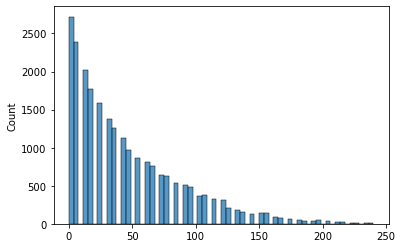

In [597]:
sns.histplot(lags['viewed-completed'])

In [598]:
portfolio

,offer_id,web,email,mobile,social,offer_type,duration,difficulty,reward
0,1,0,1,1,1,bogo,168,10,10
1,2,1,1,1,1,bogo,120,10,10
2,3,1,1,1,0,informational,96,0,0
3,4,1,1,1,0,bogo,168,5,5
4,5,1,1,0,0,discount,240,20,5
5,6,1,1,1,1,discount,168,7,3
6,7,1,1,1,1,discount,240,10,2
7,8,0,1,1,1,informational,72,0,0
8,9,1,1,1,1,bogo,120,5,5
9,10,1,1,1,0,discount,168,10,2


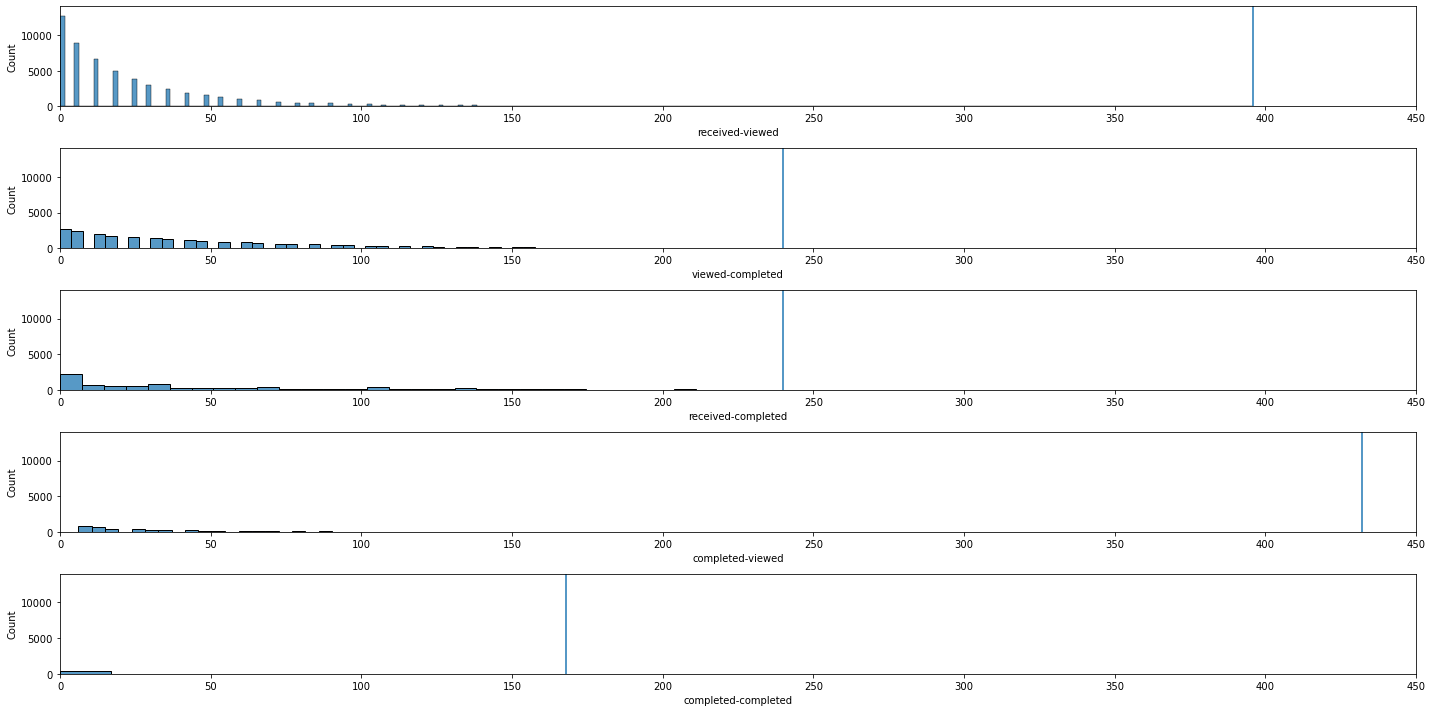

In [607]:
fig, ax = plt.subplots(len(lags), 1, figsize=(20,10))
xlims = (0, 450)
ylims = (0, 14000)
for i, key in enumerate(lags):
    sns.histplot(data=lags[key], ax=ax[i])
    ax[i].set_xlabel(key)
    ax[i].set_xlim(xlims)
    ax[i].set_ylim(ylims)
    ax[i].axvline(lags[key].max())

plt.tight_layout()

In [ ]:
# Who are teh customers which really long ass complete view numbes
# also, what's going on with complete-completed
# Errors? Code typos?

In [ ]:
def test_helper(df):
    

In [ ]:
transcript.groupby(['customer_id', 'offer_id']).apply()

# Is lining all the experiment times to 0 what we should do to faciliate analysis?

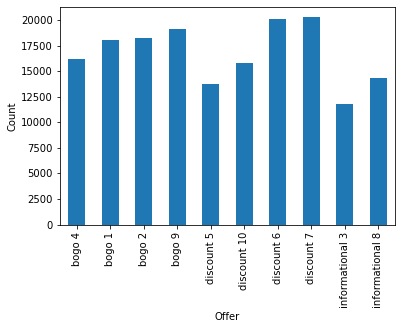

In [35]:
# Plot count of transactions by offer type and id
_ = portfolio[['offer_id', 'offer_type']].merge(transcript.offer_id.value_counts(), left_on='offer_id', right_index=True)
_ = _.rename(columns={'offer_id_y':'count'})
_ = _.sort_values(by=['offer_type', 'count'])

ax = _[['offer_type', 'count']].plot(kind='bar')
ax.set_xticklabels(_.offer_type + " " + _.offer_id_x.astype('str'))
ax.set_xlabel('Offer')
ax.set_ylabel('Count')
ax.get_legend().remove()

In [36]:
# Pivot to get transactions by offer type and count of each time
_data = transcript.groupby('event')['time'].value_counts().sort_index()

In [37]:
_data.index.get_level_values(0).unique()

Index(['offer_completed', 'offer_received', 'offer_viewed', 'transaction'], dtype='object', name='event')

In [38]:
np.arange(0,201,100)

array([  0, 100, 200])

In [39]:
_data['offer_completed'].head(1)

time
0    206
Name: time, dtype: int64

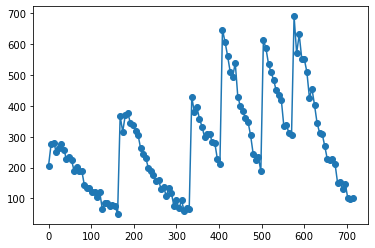

In [40]:
plt.plot(_data['offer_completed'].index, _data['offer_completed'], 'o-');

In [41]:
_data['offer_completed'].index

Int64Index([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,
            ...
            660, 666, 672, 678, 684, 690, 696, 702, 708, 714],
           dtype='int64', name='time', length=120)

<AxesSubplot:xlabel='time'>

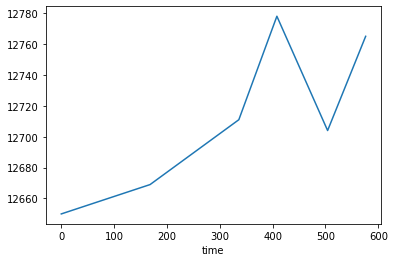

In [42]:
_data['offer_received'].plot()

<AxesSubplot:xlabel='time'>

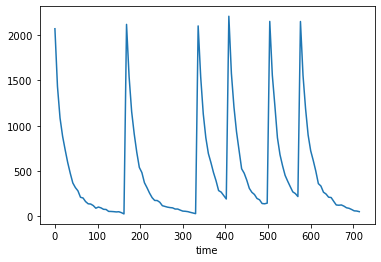

In [43]:
_data['offer_viewed'].plot()

<AxesSubplot:xlabel='time'>

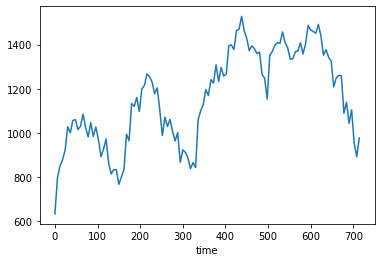

In [44]:
_data['transaction'].plot()

In [45]:
# How long do offers last?
# bascailly when offers get completed.

In [46]:
transcript.head()

,customer_id,time,event,amount,reward,offer_id
0,4,0,offer_received,NaN,NaN,4.0
1,5,0,offer_received,NaN,NaN,5.0
2,6,0,offer_received,NaN,NaN,10.0
3,7,0,offer_received,NaN,NaN,7.0
4,8,0,offer_received,NaN,NaN,2.0


## What are basic statistics and description of the dataset?

## What is the structure of the offer campaigns?

In [65]:
# Are customers getting hit with multiple offers at any one time.
# This is received events, but without the offer id, then are there duplicates
received_events.drop(columns=['offer_id']).duplicated().sum()

0

In [66]:
set(received_events.customer_id).difference(set(transcript.customer_id))

set()

In [67]:
transcript.customer_id.unique().size

17000

In [68]:
received_events.customer_id.unique().size

16994

In [69]:
# customers that never get any offers.
set(transcript.customer_id.unique()) - set(received_events.customer_id.unique())

{873, 5426, 5640, 6790, 14764, 15392}

In [70]:
# Is there anyone with duplicate times?


In [71]:
# Step one, get nodes, and their unique labels,
# which will consist of their offer number and time.
# Also a no offer ? or just spread?
# No more offers at the end.
# OK let's get the offer uniques first
offer_nodes = received_events.groupby(['offer_id', 'time'])\
               .count()\
               .index\
               .map(lambda e: 'offer' + '_' + str(int(e[0])) + '_' + str(e[1]) + 'h')
offer_nodes = pd.Series(offer_nodes)
offer_nodes = offer_nodes.append(pd.Series(['no_more_offers']))
offer_nodes = offer_nodes.reset_index(drop=True)
display(offer_nodes)



0         offer_1_0h
1       offer_1_168h
2       offer_1_336h
3       offer_1_408h
4       offer_1_504h
           ...      
56     offer_10_336h
57     offer_10_408h
58     offer_10_504h
59     offer_10_576h
60    no_more_offers
Length: 61, dtype: object

In [72]:
# Step two, get the link values, which are going to be:
# for a user that receives an offer, find out what the next offer, or if it's no offer.

#received_events.groupby('customer_id')



# Really, each user is like a chain of offer to offer to offer.

# But I need a count (source, target, value)

# Naive implementation is some kind of loop
# Onto a grid.
offer_links = pd.DataFrame(0, index=offer_nodes, columns=offer_nodes)
display(offer_links)

,offer_1_0h,offer_1_168h,offer_1_336h,offer_1_408h,offer_1_504h,offer_1_576h,offer_2_0h,offer_2_168h,offer_2_336h,offer_2_408h,...,offer_9_408h,offer_9_504h,offer_9_576h,offer_10_0h,offer_10_168h,offer_10_336h,offer_10_408h,offer_10_504h,offer_10_576h,no_more_offers
offer_1_0h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_1_168h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_1_336h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_1_408h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_1_504h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
offer_10_336h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_10_408h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_10_504h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
offer_10_576h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#ordered_events.head(10)

In [74]:
ordered_events.shape

NameError: name 'ordered_events' is not defined

In [ ]:
ordered_events.size

In [ ]:
ordered_events.iloc[0]

In [ ]:
ordered_events = received_events.sort_values(['customer_id', 'time', 'offer_id'])
customer_ids = ordered_events.customer_id.unique()
for customer in customer_ids:
    offers = ordered_events[ordered_events.customer_id == customer]
    count = 0
    while count < (offers.shape[0]):
        start_row = offers.iloc[count]
        start_node = f"offer_{str(int(start_row['offer_id']))}_{str(start_row['time'])}h"
        # For nodes up to the 2nd to last node
        if count < (offers.shape[0] - 1):
            end_row = offers.iloc[count+1]
            end_node = f"offer_{str(int(end_row['offer_id']))}_{str(end_row['time'])}h"
        # For the last node, use the no_more_offers_node
        else:
            end_node = "no_more_offers"
        # Increment the link grid
        offer_links.at[start_node, end_node] += 1
        count += 1


    
    

In [ ]:
offer_links

In [ ]:
def create_offer_links():
    """
    """
    ordered_events = 
    customer_
    for 

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3, 0], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5, 0],
      value = [8, 4, 2, 8, 4, 2, 10]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
source_nodes = []
target_nodes = []
node_values = []
for i, start_node in enumerate(offer_nodes):
    for j, end_node in enumerate(offer_nodes):
        value = offer_links.at[start_node, end_node]
        if value != 0:
            source_nodes.append(i)
            target_nodes.append(j)
            node_values.append(value)
    

In [ ]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = offer_nodes,
      color = "blue"
    ),
    link = dict(
      source = source_nodes, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_nodes,
      value = node_values
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
#At each offer time, how many customers are affected. 

In [ ]:
# Are there customers receiving more than one offer at a single time?
ordered_events[['customer_id', 'time']].duplicated().sum()

In [ ]:
# Are there customers 

Unfortunately, the Sankey is basically a pile of spaghetti. 

In [ ]:
# Let's try to get just experiment sizes for each then
# we can get the received events and then ... group by offer ids... then get the count.
received_events.groupby(['time','offer_id']).count()

In [ ]:
received_events.groupby('time').count()

In [ ]:
# How many offers do customers get?

In [ ]:
# How many people are getting the same offers repeatedly? Same type of offer?

In [65]:
# How about lining things up...
# Per offer, net effect of the offer
# Control group is the groups not getting any offers at all.
# Experiment by experiment basis.
# When people view
# When transaction complete.
# Are transactions completable without any offer?

### What is the timing of the offers?


### What is the amount of the offers (i.e. how many people they were offered to, the size of the experiment)

### What is the native customer behaviour without offers, how many people didn't have offers?

## What is the relationship between offers and spend 

### Are there customers without any offers? What is the size? What is their behaviour?

### Are there non offer and offer periods for customers?

### Which offers lead to the most spend?

### What is the relationship between demographic data and customer behaviour?